This work is based on Schreier et al, "Exploratory adaptation in large random networks." Nature Communications (2017).

Full paper available [here](https://www.nature.com/articles/ncomms14826).

This code is a python implementation of the model descrived in the paper, and incorporates 2 changes to it:
1. per-gene ideal expression level.
2. local interaction strength updates. 

With the goal of obtaining a more accurate representation of the steady state, and insight into viability/efficiency of local lifetime adaptive systems.
(Alternative splicing, Conformations of transcription factors, TF’s post-translational modifications).


In [51]:
# Import Dependencies
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import pickle

### Model definition

In [288]:
class ExploratoryAdaptationModel():
    """
    A class representing an Exploratory Adaptation Model for network dynamics.

    This model simulates the adaptation of a network to achieve a desired phenotype
    through exploratory processes.

    Attributes:
        g (nx.DiGraph): A networkx DiGraph representing the network topology.
        num_nodes (int): The number of nodes in the network.
        b (np.ndarray): An arbitrary vector of coefficients used for calculating the phenotype.
        J (np.ndarray): A matrix specifying the interaction strengths between nodes.
        T (np.ndarray): An adjacency matrix representing the network topology (constant).
        x (np.ndarray): The current values of the network components.
        y_star (np.ndarray): An arbitrary vector representing the desired phenotype.
        k (int): The distance from nodes with bad phenotype to consider for updates.
        ego_graphs (dict): A dictionary of ego graphs for each node up to distance k.
    """

    # The maximum number of steps to perform adaptation.
    MAX_STEPS = 700

    # The number of steps required to be considered in a steady state.
    STEADY_STEPS = 30

    # The learning rate for adaptation steps.
    LEARNING_RATE = 0.1

    def __init__(self, g: nx.DiGraph, k: int):
        """
        Initialize the ExploratoryAdaptationModel.

        Args:
            g (nx.DiGraph): A networkx DiGraph representing the network topology.
            k (int): The distance from nodes with bad phenotype to consider for updates.
        """
        self.g = g
        self.k = k 
        self.num_nodes = g.number_of_nodes()
        self.T = nx.adjacency_matrix(self.g).toarray()
        self.b = self.generate_random_between_0_1(size=(self.num_nodes)) 
        self.J = self.generate_random_between_0_1(size=(self.num_nodes, self.num_nodes)) 
        self.x = self.generate_random_between_0_1(size=(self.num_nodes)) 
        self.y_star = self.generate_random_between_0_1(size=(self.num_nodes)) 
        self.ego_graphs = self.generate_ego_graphs(g, self.k)


    def update(self):
        """
        Update the network state based on the current state and interaction strengths.
        """
        self.x = self.T @ self.J @ np.tanh(self.x)
        np.clip(self.x, -1, 1, out=self.x)

    def adaptation(self):
        """
        Perform the adaptation process for a maximum number of steps.

        Args:
            max_steps (int): The maximum number of steps to perform adaptation.

        Returns:
            int: The step at which the first mismatch occurred, or -1 if no mismatch
                 occurred within max_steps.
        """
        non_mismatched_in_row = 0
        first = 0
        for j in range(self.MAX_STEPS):
            self.update()
            mismatch = self.get_mismatch()
            self.adaptation_step(mismatch)
            non_mismatched_in_row += 1
            if (np.any(mismatch)):
                first = j
                non_mismatched_in_row = 0
            if non_mismatched_in_row == self.STEADY_STEPS:
                return first
        return -1
        


    def adaptation_step(self, mismatch):
        """
        Perform a single adaptation step.

        This method updates the interaction strengths (J) for nodes that are
        at most k nodes away from a mismatched node.

        Args:
            mismatch (np.ndarray): A boolean array indicating which nodes are mismatched.
        """
        mismatched_nodes = np.where(mismatch)[0]
        if len(mismatched_nodes) == 0:
            return
        nodes_to_update = np.zeros(self.num_nodes, dtype=bool)
        for n in mismatched_nodes:
            nodes_to_update[list(self.ego_graphs[n])] = True
        num_nodes_to_update = np.sum(nodes_to_update)
        random_updates = (np.random.random(num_nodes_to_update) * 2 - 1) * self.LEARNING_RATE
        self.J[nodes_to_update] += random_updates.reshape(-1, 1)
        np.clip(self.J, -1, 1, out=self.J)
        self.J[self.J < -1] = -1
        # print(f"Number of mismatched nodes: {len(mismatched_nodes)}")


    def get_phenotype(self):
        """
        Get the current phenotype of the network.
        In original paper this was a scalar, here it's a vector.

        Returns:
            np.ndarray: The current phenotype vector.
        """
        return self.x
    
    def get_mismatch(self):
        """
        Calculate the mismatch between the current phenotype and the desired phenotype.
        In original paper this was a scalar, here it's a vector.

        Returns:
            np.ndarray: A vector of mismatch values for each node.
        """
                
        epsilon = 2.17 # Controls the comfort zone size
        mu = 0.01 # Controls the steepness of the sigmoid
        M0 = 1 # Controls the maximal value 
        y = self.get_phenotype()
        return (M0/2) * (1 + np.tanh((np.abs(y - self.y_star) - epsilon) / mu))
    
    @staticmethod
    def generate_ego_graphs(g, k):
        """
        Generate ego graphs for all nodes in the network.

        Args:
            g (nx.DiGraph): The network graph.
            k (int): The radius of the ego graphs.

        Returns:
            dict: A dictionary of ego graphs for each node.
        """
        ego_graphs = {}
        for n in range(g.number_of_nodes()):
            ego_graph = nx.generators.ego_graph(g, n, radius=k, undirected=True)
            ego_graphs[n] = ego_graph
        return ego_graphs
    
    @staticmethod
    def generate_random_between_0_1(size):
        return np.random.random(size=size) * 2 - 1

### Graph sampling functions

In [ ]:
def make_strongly_connected(g):
    while not nx.is_strongly_connected(g):
        scc = list(nx.strongly_connected_components(g))
        if len(scc) > 1:
            # Add an edge between two random nodes from different components
            source = random.choice(list(scc[0]))
            target = random.choice(list(scc[1]))
            g.add_edge(source, target)
    return g

def sample_sf_exp():

    g = nx.scale_free_graph(n)
    g = make_strongly_connected(g)
    out_degrees = [val for (node, val) in g.out_degree()]
    in_degrees = []
    while (np.sum(in_degrees) != np.sum(out_degrees)):
        in_degrees = np.random.exponential(scale, n)
        in_degrees = np.round(in_degrees).astype(int)
    in_degrees = list(in_degrees)
    out_degrees = list(out_degrees)
    g = nx.directed_configuration_model(in_degrees, out_degrees)
    g = make_strongly_connected(g)
    return g

def sample_exp_sf():
    g = sample_sf_exp()
    g = g.reverse()
    return g

def sample_sf_bin():
    n = 150
    alpha = 0.02
    g = nx.scale_free_graph(n)
    g = make_strongly_connected(g)
    out_degrees = [val for (node, val) in g.out_degree()]
    in_degrees = []
    while (np.sum(in_degrees) != np.sum(out_degrees)):
        in_degrees = np.random.binomial(n, alpha, size=n)
    in_degrees = list(in_degrees)
    out_degrees = list(out_degrees)
    g = nx.directed_configuration_model(in_degrees, out_degrees)
    g = make_strongly_connected(g)
    return g

def sample_bin_sf():
    g = sample_sf_bin()
    g = g.reverse()
    return g

def sample_sf_sf():
    g = nx.scale_free_graph(150)
    g = make_strongly_connected(g)
    return g

def sample_bin_bin():
    g = nx.erdos_renyi_graph(150, 0.015, directed=True)
    g = make_strongly_connected(g)
    return g


def sample_exp_exp():
    n = 150
    scale = 3
    g = nx.DiGraph()
    g.add_nodes_from(range(n))
    out_degrees = np.random.exponential(scale, n)
    out_degrees = np.round(out_degrees).astype(int)
    degree_sequence = list(out_degrees)
    g = nx.directed_configuration_model(degree_sequence, degree_sequence)
    g = nx.DiGraph(g)
    g = make_strongly_connected(g)
    return g

def get_sampler(type):
    match type:
        case "sf_sf":
            return sample_sf_sf
        case "bin_bin":
            return sample_bin_bin
        case "exp_exp":
            return sample_exp_exp
        case "sf_exp":
            return sample_sf_exp
        case "exp_sf":
            return sample_exp_sf
        case "sf_bin":
            return sample_sf_bin
        case "bin_sf":
            return sample_bin_sf


### Model Usage

In [283]:
def save_adaptation_stats(graph_generator, pickle_name):
    k_max = 10
    steps = 700
    sims_count = 100
    stats = [[] for i in range(k_max)]
    for i in range(sims_count):
        g = graph_generator()
        for k in range(k_max):
            model = ExploratoryAdaptationModel(g, k)
            res = model.adaptation(steps)
            if (res > -1):
                print(res)
                stats[k].append(res)
        print(i, pickle_name)
    with open(pickle_name, 'wb') as handle:
        pickle.dump(stats, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return stats
    

In [ ]:
sampler_types = ["bin_bin", "sf_sf", "sf_exp", "exp_sf", "sf_bin", "bin_sf", "exp_exp"]
for sampler_type in sampler_types:
    sampler = get_sampler(sampler_type)
    save_adaptation_stats(sampler, f"{sampler_type}.pickle")

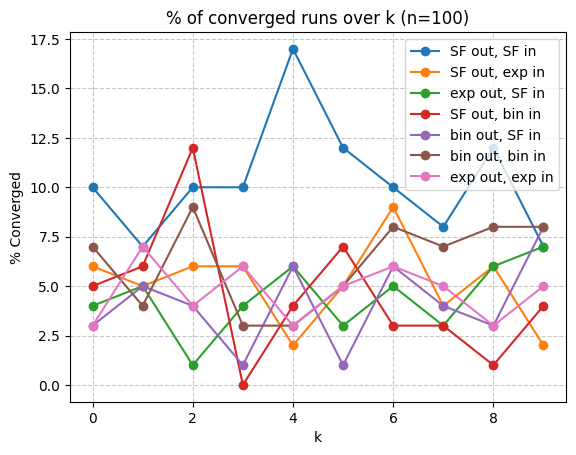

In [276]:
def plot_results():
    k_values = list(range(10))
    for name, pickle_name in [("SF out, SF in","sf_sf.pickle"), ("SF out, exp in","sf_exp.pickle"), ("exp out, SF in","exp_sf.pickle"), ("SF out, bin in","sf_bin.pickle"), ("bin out, SF in","bin_sf.pickle"), ("bin out, bin in","bin_bin.pickle"), ("exp out, exp in","exp_exp.pickle")]:
        with open(pickle_name, 'rb') as handle:
            results = pickle.load(handle)
            lengths = [len(arr) for arr in results]
            plt.plot(k_values, lengths, marker='o', label = name)
    plt.xlabel(r'k')
    plt.ylabel(r'% Converged')
    plt.title(r'% of converged runs over k (n=100)')
    plt.grid(True, linestyle='--', alpha=0.7)
    # plt.ylim(0, 100)
    plt.legend()
    plt.show()
    
plot_results()